In [ ]:
# 이미 설치된 경우 건너뛰어도 됩니다.
!pip install --user seaborn
!pip install --user opencv-python

# 모델 학습용 코드
기존에 학습된 모델을 사용한다면 이 부분은 건너뛰어도 좋습니다!

In [1]:
# 준비된 데이터 폴더 경로 설정
dir_data = r"./spao_dataset"
dir_seg = dir_data + "/seg_gray/"
dir_img = dir_data + "/img_gray/"

In [2]:
#필요한 라이브러리 불러오기
import cv2, os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid", {'axes.grid' : False}) #seaborn 자체에 흰색 격자무늬가 생성되기 때문에 제거

108.png
seg.shape=(525, 372, 3), img_is.shape=(525, 372, 3)
minimum seg = 0, maximum seg = 3, Total number of segmentation classes = 4


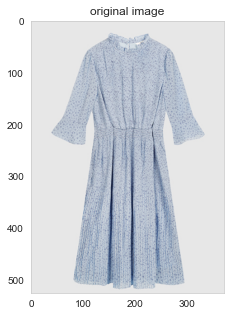

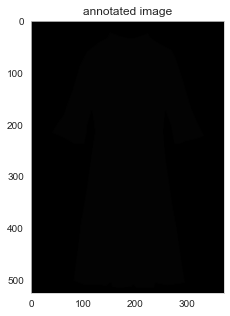

In [3]:
ldseg = np.array(os.listdir(dir_seg))
fnm = ldseg[10] # 이미지 한개를 선택 (원피스 이미지를 찾기! - 원피스만 seg 클래스가 4개로 인식 됩니다.)
print(fnm)

#기존 이미지와 주석처리된 이미지 읽기
seg = cv2.imread(dir_seg + fnm )
img_is = cv2.imread(dir_img + fnm)
print("seg.shape={}, img_is.shape={}".format(seg.shape,img_is.shape))


# 레이어 읽어서 클래스 분류하기
mi, ma = np.min(seg), np.max(seg)
n_classes = ma-mi+1
print("minimum seg = {}, maximum seg = {}, Total number of segmentation classes = {}".format(mi,ma, n_classes))


# 출력
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(img_is)
ax.set_title("original image")
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(seg)
ax.set_title("annotated image")
plt.show()

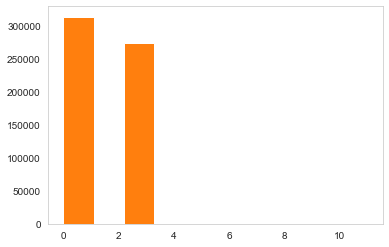

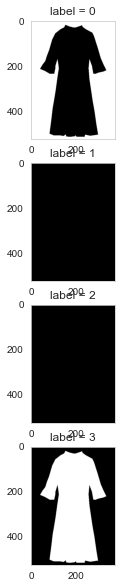

In [4]:
# 레이어 분류 확인하기  (다른 이미지를 확인하려면 윗칸의 2째줄 이미지 변경)
plt.hist(img_is.ravel(), 10, [0,10])
plt.hist(seg.ravel(), 10, [0,11])

fig = plt.figure(figsize=(60,10))
for k in range(mi,ma+1):
    ax = fig.add_subplot(4,n_classes/4,k+1)
    ax.imshow((seg == k)*1.0)
    ax.set_title("label = {}".format(k))

plt.show()

#### FCN은 이미지의 크기를 조정할 필요는 없지만, 정확도를 위해 기존 모델을 학습하는 동안은 데이터의 크기를 동일하게 조정하였습니다.

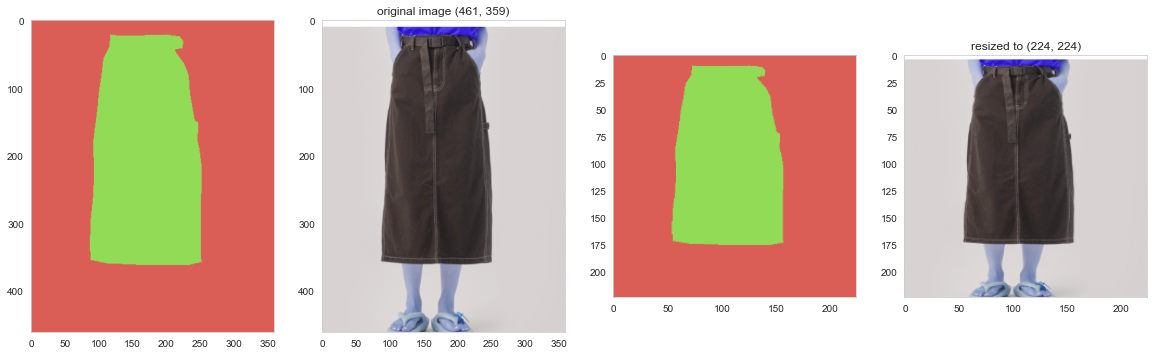

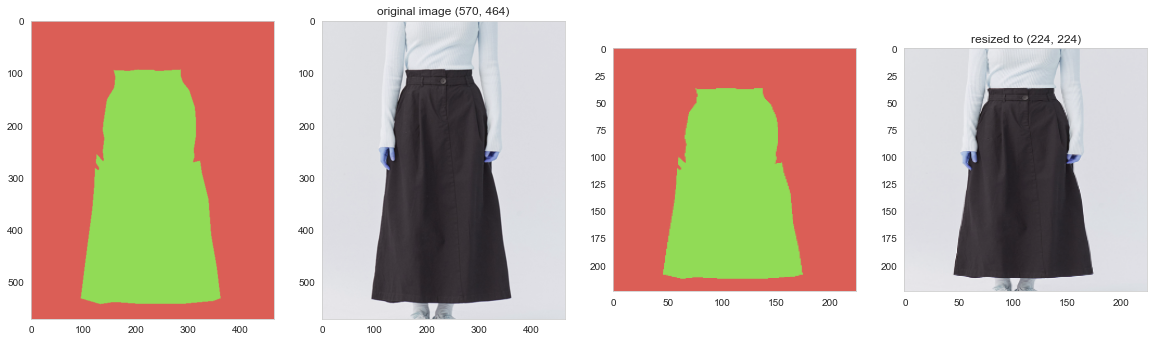

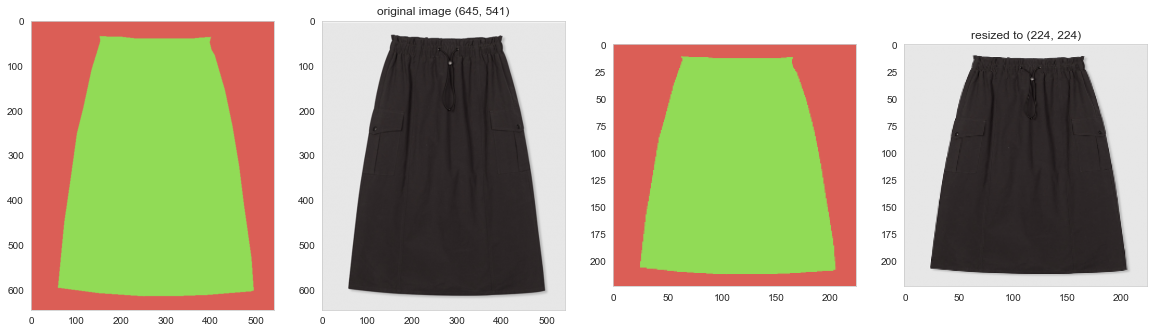

In [5]:
import random

def give_color_to_seg_img(seg,n_classes):    # 각 클래스에 색상 입히기
    '''
    seg : (input_width,input_height,3)
    '''
    
    if len(seg.shape)==3:
        seg = seg[:,:,0]
    seg_img = np.zeros( (seg.shape[0],seg.shape[1],3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

input_height , input_width = 224 , 224
output_height , output_width = 224 , 224


ldseg = np.array(os.listdir(dir_seg))
for fnm in ldseg[np.random.choice(len(ldseg),3,replace=False)]:
    fnm = fnm.split(".")[0]
    seg = cv2.imread(dir_seg + fnm + ".png")
    img_is = cv2.imread(dir_img + fnm + ".png")
    seg_img = give_color_to_seg_img(seg,n_classes)

    fig = plt.figure(figsize=(20,40)) 
    ax = fig.add_subplot(1,4,1)
    ax.imshow(seg_img)
    
    ax = fig.add_subplot(1,4,2)
    ax.imshow(img_is/255.0)
    ax.set_title("original image {}".format(img_is.shape[:2]))
    
    ax = fig.add_subplot(1,4,3)
    ax.imshow(cv2.resize(seg_img,(input_height , input_width)))
    
    ax = fig.add_subplot(1,4,4)
    ax.imshow(cv2.resize(img_is,(output_height , output_width))/255.0)
    ax.set_title("resized to {}".format((output_height , output_width)))
    plt.show()

In [6]:
# 배열 불러들이는 메서드
def getImageArr( path , width , height ):
        img = cv2.imread(path, 1)
        img = np.float32(cv2.resize(img, ( width , height ))) / 127.5 - 1   #이미지 크기 조정
        return img

def getSegmentationArr( path , nClasses ,  width , height  ):

    seg_labels = np.zeros((  height , width  , nClasses ))
    img = cv2.imread(path, 1)
    img = cv2.resize(img, ( width , height ))    # 이미지 크기 조정
    img = img[:, : , 0]

    for c in range(nClasses):
        seg_labels[: , : , c ] = (img == c ).astype(int)
    ##seg_labels = np.reshape(seg_labels, ( width*height,nClasses  ))
    return seg_labels

images = os.listdir(dir_img)
images.sort()
segmentations  = os.listdir(dir_seg)
segmentations.sort()
    
X = []
Y = []
for im , seg in zip(images,segmentations) :    # 이미지 불러들이는 과정에서 오류 확인
    try:
        X.append( getImageArr(dir_img + im , 224 , 224 )  ) # 224 = input_width, input_height (으로 변경해도 됨)
        Y.append( getSegmentationArr( dir_seg + seg , n_classes , 224 , 224 )  ) # 224 = output_width, output_height
    except cv2.error as e:
        print(im);
        
X, Y = np.array(X) , np.array(Y)
print(X.shape,Y.shape)

.ipynb_checkpoints
(119, 224, 224, 3) (119, 224, 224, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


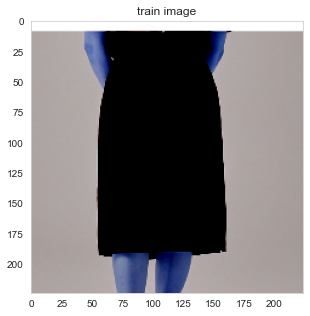

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


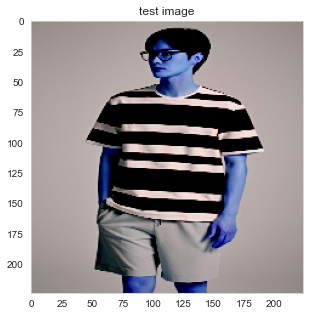

In [7]:
# 학습 세트 섞기, 학습/테스트 셋 분류하기
from sklearn.utils import shuffle
train_rate = 0.65
index_train = np.random.choice(X.shape[0],int(X.shape[0]*train_rate),replace=False)
index_test  = list(set(range(X.shape[0])) - set(index_train))

    
X, Y = shuffle(X,Y)
X_train, Y_train = X[index_train],Y[index_train]
X_test, Y_test = X[index_test],Y[index_test]

#train dataset 확인하기
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_train[9])
ax.set_title("train image")
plt.show()

fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(1,1,1)
ax.imshow(X_test[9])
ax.set_title("test image")
plt.show()

# 모델 가동

In [8]:
## 모델에 필요한 라이브러리 불러오기
import tensorflow as tf
from tensorflow.python.keras.backend import set_session
import keras, sys, time, warnings
from keras.models import *
from keras.layers import *
import pandas as pd 
warnings.filterwarnings("ignore")

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
config = tf.compat.v1.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.95
config.gpu_options.visible_device_list = "2" 

print("python {}".format(sys.version))
print("keras version {}".format(keras.__version__)); del keras
print("tensorflow version {}".format(tf.__version__))   #버전 확인용

python 3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]
keras version 2.4.3
tensorflow version 2.4.1


In [9]:
# 기존 학습된 모델 불러오기 (신규 모델 학습시 제거)
## 모델 다운로드 주소 : https://drive.google.com/file/d/1u9sruBWJ46Jr1_rpWLk0eiA1ce2DHmm-/view?usp=sharing
VGG_Weights_path = "./my_h5_model_0609.h5"   # my_h5_model_0609.h5 파일 위치 수정하기 / 새로 학습된 모델 저장시 명칭 변경하기
model = load_model(VGG_Weights_path)    ## VGG_Weights_path = Prev_Model_path (추후 변수 명칭 수정 예정)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 224, 224, 64) 1792        input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 224, 224, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 112, 112, 64) 0           block1_conv2[0][0]               
____________________________________________________________________________________________

In [ ]:
# 신규 모델 생성
def FCN8( nClasses ,  input_height=224, input_width=224):
    assert input_height%32 == 0
    assert input_width%32 == 0
    IMAGE_ORDERING =  "channels_last" 

    img_input = Input(shape=(input_height,input_width, 3))
    
    ## Block 1
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', data_format=IMAGE_ORDERING )(img_input)
    x = Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool', data_format=IMAGE_ORDERING )(x)
    f1 = x
    
    # Block 2
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool', data_format=IMAGE_ORDERING )(x)
    f2 = x

    # Block 3
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3', data_format=IMAGE_ORDERING )(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool', data_format=IMAGE_ORDERING )(x)
    pool3 = x

    # Block 4
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3', data_format=IMAGE_ORDERING )(x)
    pool4 = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool', data_format=IMAGE_ORDERING )(x)## (None, 14, 14, 512) 

    # Block 5
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1', data_format=IMAGE_ORDERING )(pool4)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2', data_format=IMAGE_ORDERING )(x)
    x = Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3', data_format=IMAGE_ORDERING )(x)
    pool5 = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool', data_format=IMAGE_ORDERING )(x)## (None, 7, 7, 512)


    vgg  = Model(  img_input , pool5  )
    
    n = 4096
    o = ( Conv2D( n , ( 7 , 7 ) , activation='relu' , padding='same', name="conv6", data_format=IMAGE_ORDERING))(pool5)
    conv7 = ( Conv2D( n , ( 1 , 1 ) , activation='relu' , padding='same', name="conv7", data_format=IMAGE_ORDERING))(o)
    
    
    ## 4배 upsamping (pool4 layer)
    conv7_4 = Conv2DTranspose( nClasses , kernel_size=(4,4) ,  strides=(4,4) , use_bias=False, data_format=IMAGE_ORDERING )(conv7)
    ## (None, 224, 224, 10)
    ## 2배 upsampling(pool411)
    pool411 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool4_11", data_format=IMAGE_ORDERING))(pool4)
    pool411_2 = (Conv2DTranspose( nClasses , kernel_size=(2,2) ,  strides=(2,2) , use_bias=False, data_format=IMAGE_ORDERING ))(pool411)
    
    pool311 = ( Conv2D( nClasses , ( 1 , 1 ) , activation='relu' , padding='same', name="pool3_11", data_format=IMAGE_ORDERING))(pool3)
        
    o = Add(name="add")([pool411_2, pool311, conv7_4 ])
    o = Conv2DTranspose( nClasses , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False, data_format=IMAGE_ORDERING )(o)
    o = (Activation('softmax'))(o)
    
    model = Model(img_input, o)

    return model

model = FCN8(nClasses     = n_classes,  
             input_height = 224, 
             input_width  = 224)
model.summary()

### 학습하기

In [11]:
from keras import optimizers


sgd = optimizers.SGD(lr=1E-2, decay=5**(-4), momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=['accuracy'])

hist1 = model.fit(X_train,Y_train,
                  validation_data=(X_test,Y_test),
                  batch_size=32,epochs=5, verbose=2)  # epoch 변경하여 횟수 조정

Epoch 1/5
3/3 - 51s - loss: 0.2569 - accuracy: 0.9052 - val_loss: 0.2883 - val_accuracy: 0.8904
Epoch 2/5
3/3 - 51s - loss: 0.2376 - accuracy: 0.9132 - val_loss: 0.2731 - val_accuracy: 0.9043
Epoch 3/5
3/3 - 49s - loss: 0.2306 - accuracy: 0.9134 - val_loss: 0.3018 - val_accuracy: 0.8938
Epoch 4/5
3/3 - 50s - loss: 0.2174 - accuracy: 0.9209 - val_loss: 0.3111 - val_accuracy: 0.8827
Epoch 5/5
3/3 - 49s - loss: 0.2210 - accuracy: 0.9166 - val_loss: 0.3914 - val_accuracy: 0.8603


### 학습 결과 출력

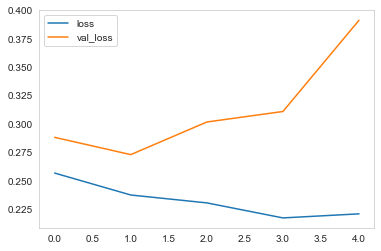

In [12]:
for key in ['loss', 'val_loss']:
    plt.plot(hist1.history[key],label=key)
plt.legend()
plt.show()

In [13]:
y_pred = model.predict(X_test)
y_predi = np.argmax(y_pred, axis=3)
y_testi = np.argmax(Y_test, axis=3)
print(y_testi.shape,y_predi.shape)

# 아직 수정중인 부분(추출된 부분에 대한 classification 출력하기 위함)
#predictions = model.predict(X_test)
#class_names = ['Bottom', 'Top', 'One-piece']

#class_names[np.argmax(predictions)]

(42, 224, 224) (42, 224, 224)


In [14]:
def IoU(Yi,y_predi):
    ## mean Intersection over Union
    ## Mean IoU = TP/(FN + TP + FP)

    IoUs = []
    Nclass = int(np.max(Yi)) + 1
    for c in range(Nclass):
        TP = np.sum( (Yi == c)&(y_predi==c) )
        FP = np.sum( (Yi != c)&(y_predi==c) )
        FN = np.sum( (Yi == c)&(y_predi != c)) 
        IoU = TP/float(TP + FP + FN)
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        IoUs.append(IoU)
    mIoU = np.mean(IoUs)
    print("_________________")
    print("Mean IoU: {:4.3f}".format(mIoU))
    
IoU(y_testi,y_predi)

class 00: #TP=1255282, #FP= 19435, #FN=149479, IoU=0.881
class 01: #TP=453481, #FP=243501, #FN=18479, IoU=0.634
class 02: #TP= 25517, #FP= 10185, #FN=38137, IoU=0.346
class 03: #TP= 78752, #FP= 21239, #FN=88265, IoU=0.418
_________________
Mean IoU: 0.570


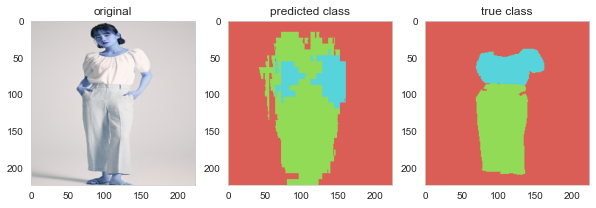

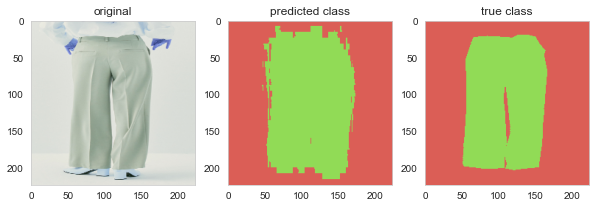

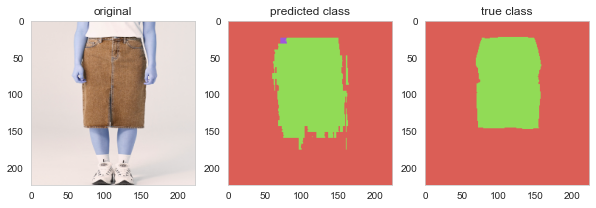

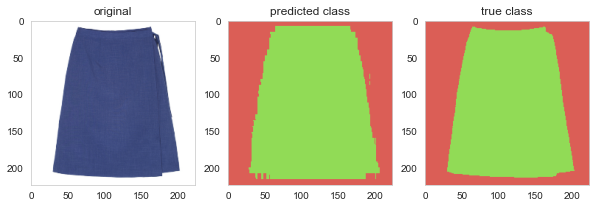

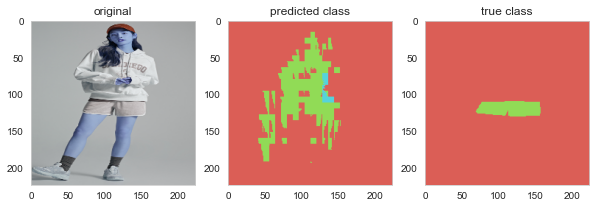

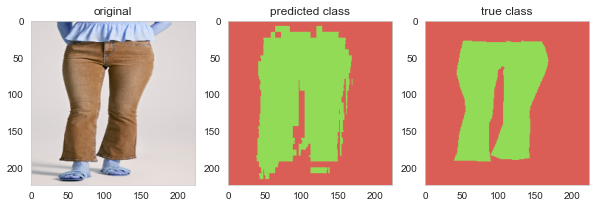

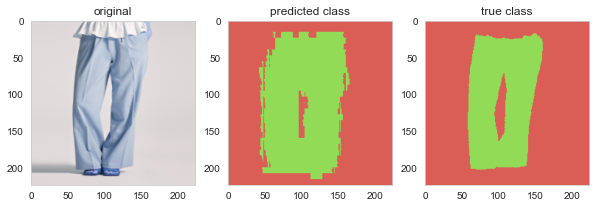

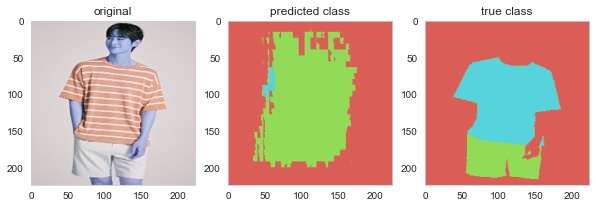

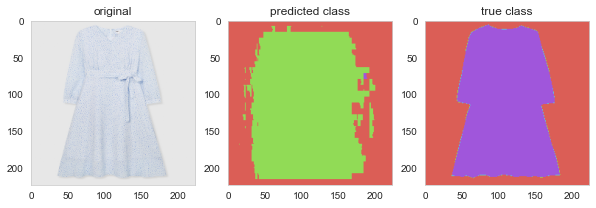

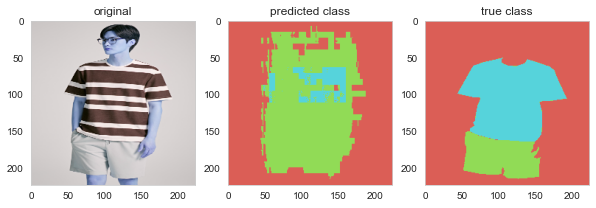

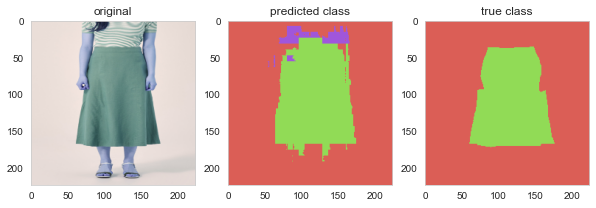

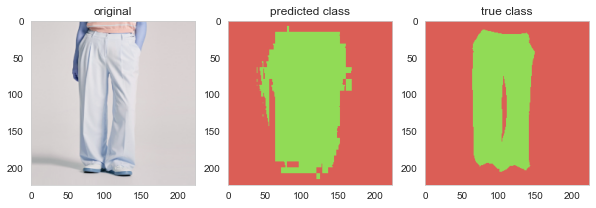

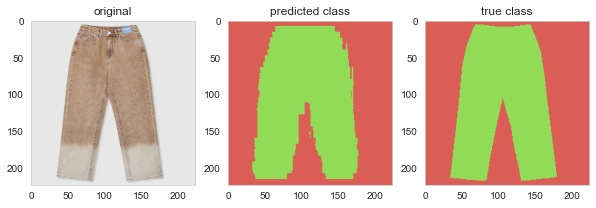

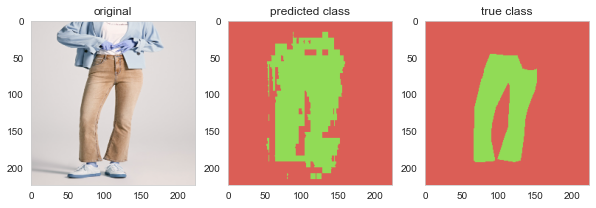

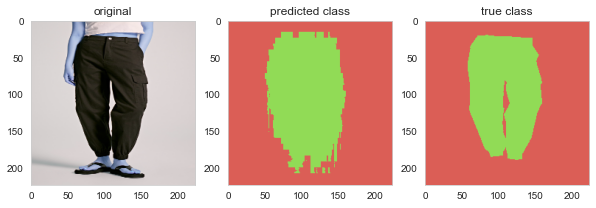

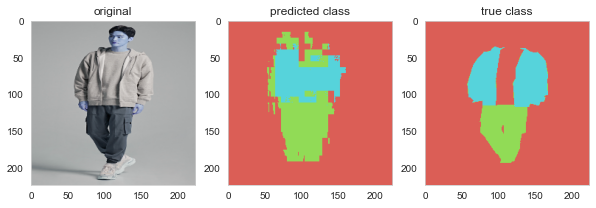

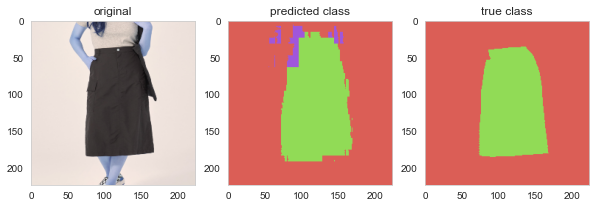

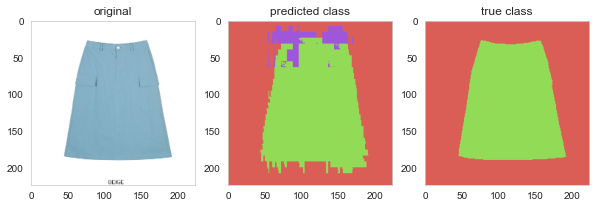

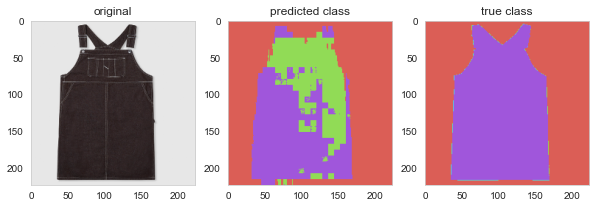

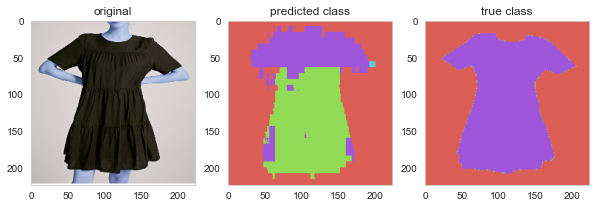

In [15]:
for i in range(20): # 숫자 조정하여 출력 개수 조정
    img_is  = (X_test[i] + 1)*(255.0/2)
    seg = y_predi[i]
    segtest = y_testi[i]

    fig = plt.figure(figsize=(10,30))    
    ax = fig.add_subplot(1,3,1)
    ax.imshow(img_is/255.0)
    ax.set_title("original")
    
    ax = fig.add_subplot(1,3,2)
    ax.imshow(seg)
    ax.imshow(give_color_to_seg_img(seg,n_classes))
    ax.set_title("predicted class")
    plt.imsave('./spao_dataset/pred/pred_'+str(i)+'.png', seg)
    
    ax = fig.add_subplot(1,3,3)
    ax.imshow(segtest)
    ax.imshow(give_color_to_seg_img(segtest,n_classes))
    ax.set_title("true class")

    
    plt.show()

In [16]:
# 마지막 학습모델 저장
model.save("my_h5_model_0611.h5")